In [ ]:
# Import the required libraries
from numpy import zeros, ones
from numpy.random import randn, randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import pickle

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
os.mkdir('/content/drive/MyDrive/GAN/g_model')
os.mkdir('/content/drive/MyDrive/GAN/d_model')

os.mkdir('/content/drive/MyDrive/GAN/d_pkl')
os.mkdir('/content/drive/MyDrive/GAN/gan model')

os.mkdir('/content/drive/MyDrive/GAN/g_pkl')

In [ ]:
os.mkdir('/content/drive/MyDrive/GAN/gan 128x128')

In [ ]:
# define the standalone discriminator model
# Input would be 128x128x3 images and the output would be a binary (using sigmoid)
#Remember that the discriminator is just a binary classifier for true/fake images.
def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 64x64
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)      

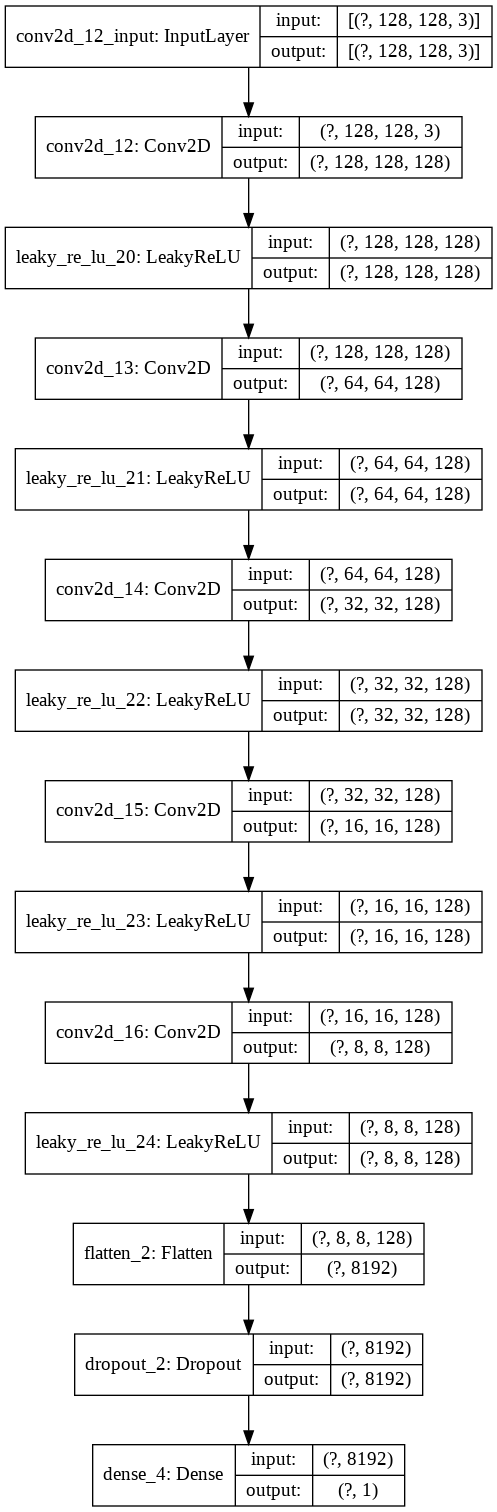

In [ ]:
#Verify the model summary
test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr, to_file='disc_model.png', show_shapes=True)

In [ ]:
# define the standalone generator model
# Generator must generate 128x128x3 images that can be fed into the discriminator. 
# So, we start with enough nodes in the dense layer that can be gradually upscaled
#to 128x128x3. 
#Remember that the input would be a latent vector (usually size 100)
def define_generator(latent_dim):
	model = Sequential()
	# Define number of nodes that can be gradually reshaped and upscaled to 128x128x3
	n_nodes = 128 * 8 * 8 #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 128x128x3
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #tanh goes from [-1,1]
	return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)      

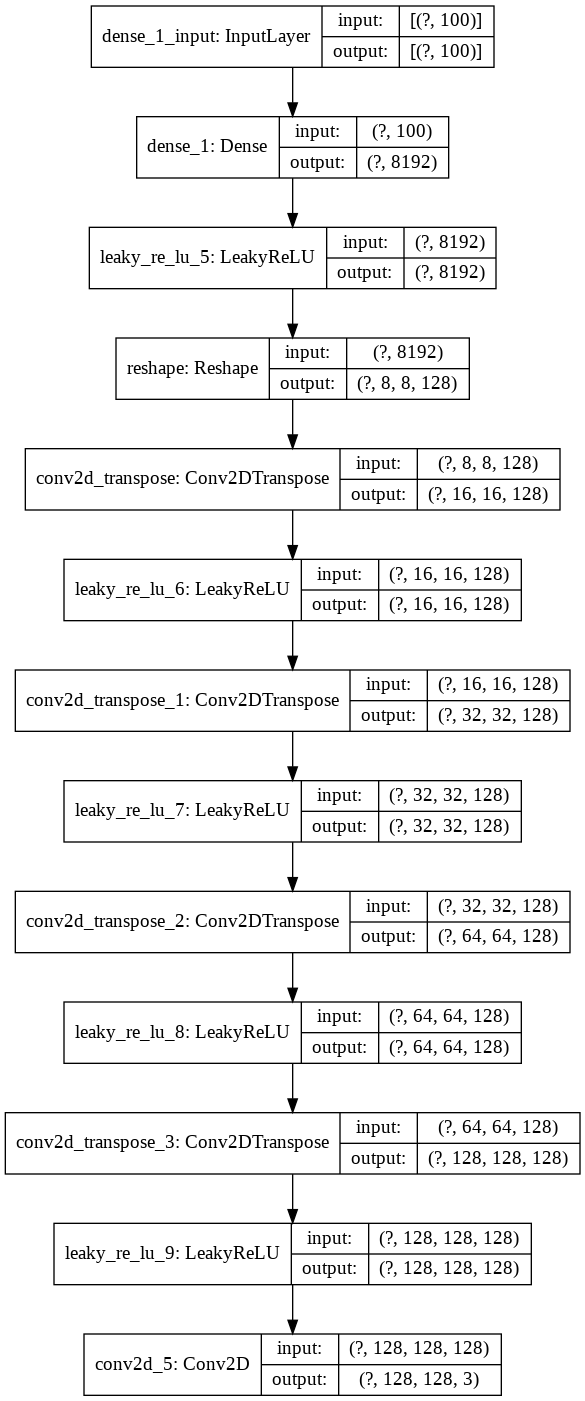

In [ ]:
test_gen = define_generator(100)
print(test_gen.summary())
plot_model(test_gen, to_file='generator_model.png', show_shapes=True)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128, 128, 3)       1901059   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 602113    
Total params: 2,503,172
Trainable params: 1,901,059
Non-trainable params: 602,113
_________________________________________________________________
None


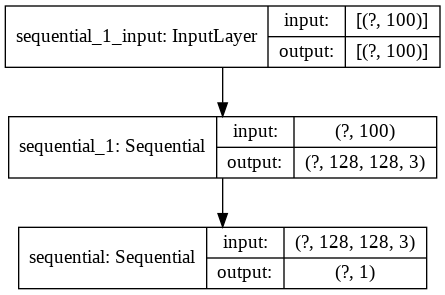

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())
plot_model(test_gan, to_file='combined_model.png', show_shapes=True)

In [ ]:
# Function to sample some random real images
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1)) # Class labels for real images are 1
	return X, y

In [ ]:
# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator. 
	return x_input

In [ ]:
# Function to generate fake images using latent vectors
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples) #Generate latent points as input to the generator
	X = g_model.predict(x_input) #Use the generator to generate fake images
	y = zeros((n_samples, 1)) # Class labels for fake images are 0
	return X, y

In [ ]:
# Function to save Plots after every n number of epochs
def save_plot(examples, epoch, n=10):
	# scale images from [-1,1] to [0,1] so we can plot
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	# save plot to a file so we can view how generated images evolved over epochs
  #sample_dir = '/content/drive/MyDrive/gan 64x64'
	filename = '/content/drive/MyDrive/GAN/gan 128x128/generated_plot_128x128_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:

# Function to summarize performance periodically. 
# 
def summarize_performance(epoch, g_model, d_model, gan_model, dataset, latent_dim, n_samples=100):
	# Fetch real images
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real images - get accuracy
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# Generate fake images
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake images - get accuracy
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# Print discriminate accuracies on ral and fake images. 
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save generated images periodically using the save_plot function
	save_plot(x_fake, epoch)
	# save the generator model
	g_filename = '/content/drive/MyDrive/GAN/g_model/generator_model_128x128_%03d.h5' % (epoch+1)
	g_model.save(g_filename)
	d_filename = '/content/drive/MyDrive/GAN/d_model/discrimnator_model_128x128_%03d.h5' % (epoch+1)
	d_model.save(d_filename)
	g_filepath = "/content/drive/MyDrive/GAN/g_pkl/generator_model_128x128_%03d.pkl" % (epoch+1)
	d_filepath = "/content/drive/MyDrive/GAN/d_pkl/discrimnator_model_128x128_%03d.pkl" % (epoch+1)
	gan_filename = '/content/drive/MyDrive/GAN/gan model/gan_model_128x128_%03d.h5' % (epoch+1)
	gan_model.save(gan_filename)
 
	with open(g_filepath, 'wb') as fp:
		pickle.dump(
			{
				'opt': gan_model.optimizer.get_config(),
				'epoch': epoch+1
			# Add additional keys if you need to store more values
			}, fp, protocol=pickle.HIGHEST_PROTOCOL)
	
		with open(d_filepath, 'wb') as fp:
			pickle.dump(
			{
				'opt': d_model.optimizer.get_config(),
				'epoch': epoch+1
			# Add additional keys if you need to store more values
			}, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# train the generator and discriminator by enumerating batches and epochs. 
#

def train(g_model, d_model, gan_model, dataset, latent_dim, epoch, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2) #Disc. trained on half batch real and half batch fake images
	#  enumerate epochs
	for i in range(epoch,n_epochs):
		# enumerate batches 
		for j in range(bat_per_epo):
			# Fetch random 'real' images
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Train the discriminator using real images
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' images 
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# Train the discriminator using fake images
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# Generate latent vectors as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# Label generated (fake) mages as 1 to fool the discriminator 
			y_gan = ones((n_batch, 1))
			# Train the generator (via the discriminator's error)
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# Report disc. and gen losses. 
			print('Epoch>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:

#Now that we defined all necessary functions, let us load data and train the GAN.
# Dataset from: https://susanqq.github.io/UTKFace/
import os
import numpy as np
import cv2
from PIL import Image
import random

In [ ]:
n=256 #Number of images to read from the directory. (For training)
SIZE = 128 #Resize images to this size
all_img_list = os.listdir('/content/drive/MyDrive/Fyp Dataset (rar file extraction)/train/P') 

dataset_list = random.sample(all_img_list, n) #Get n random images from the directory



In [ ]:
#Read images, resize and capture into a numpy array
dataset = []
for img in dataset_list:
    temp_img = cv2.imread("/content/drive/MyDrive/Fyp Dataset (rar file extraction)/train/P/" + img)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB) #opencv reads images as BGR so let us convert back to RGB
    temp_img = Image.fromarray(temp_img)
    temp_img = temp_img.resize((SIZE, SIZE)) #Resize
    dataset.append(np.array(temp_img))   

dataset = np.array(dataset) #Convert the list to numpy array

In [ ]:
#Rescale to [-1, 1] - remember that the generator uses tanh activation that goes from -1,1
dataset = dataset.astype('float32')
	# scale from [0,255] to [-1,1]
dataset = (dataset - 127.5) / 127.5

# size of the latent space
latent_dim = 100
# create the discriminator using our pre-defined function
d_model = define_discriminator()
# create the generator using our pre-defined function
g_model = define_generator(latent_dim)
# create the gan  using our pre-defined function
gan_model = define_gan(g_model, d_model)

In [ ]:
! pip uninstall tensorflow
! pip install tensorflow==2.3.0

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 39 kB/s 
     |████████████████████████████████| 20.1 MB 78.3 MB/s 
     |████████████████████████████████| 2.9 MB 83.0 MB/s 
     |████████████████████████████████| 459 kB 94.5 MB/s 
  Attempting 

In [ ]:
import tensorflow as tf
print(tf. __version__) 


2.3.0


In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=0, n_epochs=50)

Epoch>1, 1/2, d1=0.730, d2=0.694 g=0.693
Epoch>1, 2/2, d1=0.654, d2=0.694 g=0.692
Epoch>2, 1/2, d1=0.591, d2=0.695 g=0.692
Epoch>2, 2/2, d1=0.475, d2=0.696 g=0.692
Epoch>3, 1/2, d1=0.294, d2=0.700 g=0.690
Epoch>3, 2/2, d1=0.108, d2=0.709 g=0.687
Epoch>4, 1/2, d1=0.033, d2=0.729 g=0.682
Epoch>4, 2/2, d1=0.020, d2=0.742 g=0.700
Epoch>5, 1/2, d1=0.015, d2=0.671 g=0.810
Epoch>5, 2/2, d1=0.025, d2=0.603 g=0.879
Epoch>6, 1/2, d1=0.023, d2=0.596 g=0.869
Epoch>6, 2/2, d1=0.034, d2=0.603 g=0.841
Epoch>7, 1/2, d1=0.016, d2=0.586 g=0.873
Epoch>7, 2/2, d1=0.023, d2=0.555 g=0.925
Epoch>8, 1/2, d1=0.002, d2=0.503 g=1.054
Epoch>8, 2/2, d1=0.003, d2=0.438 g=1.289
Epoch>9, 1/2, d1=0.020, d2=0.502 g=1.638
Epoch>9, 2/2, d1=0.014, d2=0.535 g=2.765
Epoch>10, 1/2, d1=0.072, d2=0.045 g=3.765
Epoch>10, 2/2, d1=0.281, d2=0.102 g=2.136
>Accuracy real: 100%, fake: 99%
Epoch>11, 1/2, d1=0.276, d2=0.778 g=2.064
Epoch>11, 2/2, d1=0.000, d2=1.705 g=2.619
Epoch>12, 1/2, d1=0.001, d2=0.135 g=6.690
Epoch>12, 2/2, d1=0.

In [ ]:
G_MODEL_PATH = r'/content/drive/MyDrive/GAN/generator_model_128x128_65000.h5'
#LOADING Generator
g_model = load_model(G_MODEL_PATH,compile=False)
#/content/drive/MyDrive/GAN/g_model/generator_model_128x128_31000.h5
#/content/drive/MyDrive/GAN/summarise models/generator_model_128x128_%03d.pkl' % (epoch+1)
#G_OPT_PATH = "/content/drive/MyDrive/GAN/g_pkl/generator_model_128x128_120.pkl"

In [ ]:
D_MODEL_PATH = r'/content/drive/MyDrive/GAN/discrimnator_model_128x128_65000.h5'
#/content/drive/MyDrive/GAN/summarise models/generator_model_128x128_%03d.pkl' % (epoch+1)
D_OPT_PATH = r"/content/drive/MyDrive/GAN/discrimnator_model_128x128_65000.pkl"

In [ ]:
GAN_MODEL_PATH = r'/content/drive/MyDrive/GAN/gan_model_128x128_65000.h5'
#/content/drive/MyDrive/GAN/summarise models/generator_model_128x128_%03d.pkl' % (epoch+1)
GAN_OPT_PATH = r"/content/drive/MyDrive/GAN/generator_model_128x128_65000.pkl"

In [ ]:
#LOADING Generator
g_model = load_model(G_MODEL_PATH,compile=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle

def load_model_data(model_path, opt_path):
    model = load_model(model_path,compile=False)
    with open(opt_path, 'rb') as fp:
      d = pickle.load(fp)
      epoch = d['epoch']
      opt = d['opt']
      return epoch, model, opt
#LOADING GAN
epoch, gan_model, g_opt = load_model_data(GAN_MODEL_PATH, GAN_OPT_PATH)

# note: often it is not necessary to recompile the model
opt = Adam(learning_rate=0.0002, beta_1=0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=opt)

In [ ]:
#LOADING Discriminator
epoch, d_model, d_opt = load_model_data(D_MODEL_PATH, D_OPT_PATH)
# note: often it is not necessary to recompile the model
opt = Adam(learning_rate=0.0002, beta_1=0.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#tf.config.run_functions_eagerly(True)
print(epoch, d_model, d_opt)


65000 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff102f16710> {'name': 'Adam', 'learning_rate': 0.0002, 'decay': 0.0, 'beta_1': 0.5, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=100)
 # train_model(model, initial_epoch=epoch, max_epochs=6)

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=1000)

Epoch>101, 1/2, d1=0.667, d2=0.303 g=0.004
Epoch>101, 2/2, d1=0.596, d2=0.317 g=0.003
Epoch>102, 1/2, d1=0.537, d2=0.310 g=0.002
Epoch>102, 2/2, d1=0.625, d2=0.278 g=0.002
Epoch>103, 1/2, d1=0.462, d2=0.308 g=0.001
Epoch>103, 2/2, d1=0.531, d2=0.284 g=0.001
Epoch>104, 1/2, d1=0.489, d2=0.339 g=0.001
Epoch>104, 2/2, d1=0.477, d2=0.271 g=0.001
Epoch>105, 1/2, d1=0.577, d2=0.271 g=0.000
Epoch>105, 2/2, d1=0.466, d2=0.297 g=0.000
Epoch>106, 1/2, d1=0.522, d2=0.290 g=0.000
Epoch>106, 2/2, d1=0.484, d2=0.283 g=0.000
Epoch>107, 1/2, d1=0.563, d2=0.268 g=0.000
Epoch>107, 2/2, d1=0.551, d2=0.294 g=0.000
Epoch>108, 1/2, d1=0.487, d2=0.338 g=0.000
Epoch>108, 2/2, d1=0.537, d2=0.254 g=0.000
Epoch>109, 1/2, d1=0.506, d2=0.311 g=0.000
Epoch>109, 2/2, d1=0.496, d2=0.343 g=0.000
Epoch>110, 1/2, d1=0.573, d2=0.290 g=0.000
Epoch>110, 2/2, d1=0.487, d2=0.312 g=0.000
>Accuracy real: 76%, fake: 92%
Epoch>111, 1/2, d1=0.392, d2=0.247 g=0.000
Epoch>111, 2/2, d1=0.585, d2=0.293 g=0.000
Epoch>112, 1/2, d1=0.52

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=1500)

Epoch>991, 1/2, d1=0.546, d2=0.271 g=0.000
Epoch>991, 2/2, d1=0.526, d2=0.323 g=0.000
Epoch>992, 1/2, d1=0.543, d2=0.283 g=0.000
Epoch>992, 2/2, d1=0.518, d2=0.299 g=0.000
Epoch>993, 1/2, d1=0.545, d2=0.267 g=0.000
Epoch>993, 2/2, d1=0.425, d2=0.302 g=0.000
Epoch>994, 1/2, d1=0.515, d2=0.316 g=0.000
Epoch>994, 2/2, d1=0.533, d2=0.319 g=0.000
Epoch>995, 1/2, d1=0.581, d2=0.287 g=0.000
Epoch>995, 2/2, d1=0.505, d2=0.355 g=0.000
Epoch>996, 1/2, d1=0.495, d2=0.265 g=0.000
Epoch>996, 2/2, d1=0.539, d2=0.303 g=0.000
Epoch>997, 1/2, d1=0.508, d2=0.261 g=0.000
Epoch>997, 2/2, d1=0.516, d2=0.293 g=0.000
Epoch>998, 1/2, d1=0.644, d2=0.292 g=0.000
Epoch>998, 2/2, d1=0.518, d2=0.320 g=0.000
Epoch>999, 1/2, d1=0.536, d2=0.317 g=0.000
Epoch>999, 2/2, d1=0.554, d2=0.342 g=0.000
Epoch>1000, 1/2, d1=0.483, d2=0.315 g=0.000
Epoch>1000, 2/2, d1=0.560, d2=0.292 g=0.000
>Accuracy real: 84%, fake: 98%
Epoch>1001, 1/2, d1=0.373, d2=0.261 g=0.000
Epoch>1001, 2/2, d1=0.512, d2=0.312 g=0.000
Epoch>1002, 1/2, d1

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=2500)

Epoch>991, 1/2, d1=0.516, d2=0.310 g=0.000
Epoch>991, 2/2, d1=0.462, d2=0.290 g=0.000
Epoch>992, 1/2, d1=0.508, d2=0.307 g=0.000
Epoch>992, 2/2, d1=0.523, d2=0.254 g=0.000
Epoch>993, 1/2, d1=0.530, d2=0.279 g=0.000
Epoch>993, 2/2, d1=0.529, d2=0.301 g=0.000
Epoch>994, 1/2, d1=0.536, d2=0.259 g=0.000
Epoch>994, 2/2, d1=0.563, d2=0.342 g=0.000
Epoch>995, 1/2, d1=0.457, d2=0.308 g=0.000
Epoch>995, 2/2, d1=0.591, d2=0.326 g=0.000
Epoch>996, 1/2, d1=0.521, d2=0.280 g=0.000
Epoch>996, 2/2, d1=0.572, d2=0.391 g=0.000
Epoch>997, 1/2, d1=0.584, d2=0.298 g=0.000
Epoch>997, 2/2, d1=0.450, d2=0.278 g=0.000
Epoch>998, 1/2, d1=0.561, d2=0.267 g=0.000
Epoch>998, 2/2, d1=0.456, d2=0.280 g=0.000
Epoch>999, 1/2, d1=0.475, d2=0.322 g=0.000
Epoch>999, 2/2, d1=0.500, d2=0.318 g=0.000
Epoch>1000, 1/2, d1=0.548, d2=0.296 g=0.000
Epoch>1000, 2/2, d1=0.594, d2=0.292 g=0.000
>Accuracy real: 78%, fake: 93%
Epoch>1001, 1/2, d1=0.398, d2=0.278 g=0.000
Epoch>1001, 2/2, d1=0.474, d2=0.278 g=0.000
Epoch>1002, 1/2, d1

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=4500)

Epoch>2501, 1/2, d1=0.508, d2=0.260 g=0.000
Epoch>2501, 2/2, d1=0.520, d2=0.264 g=0.000
Epoch>2502, 1/2, d1=0.479, d2=0.319 g=0.000
Epoch>2502, 2/2, d1=0.532, d2=0.303 g=0.000
Epoch>2503, 1/2, d1=0.517, d2=0.312 g=0.000
Epoch>2503, 2/2, d1=0.489, d2=0.260 g=0.000
Epoch>2504, 1/2, d1=0.537, d2=0.373 g=0.000
Epoch>2504, 2/2, d1=0.579, d2=0.334 g=0.000
Epoch>2505, 1/2, d1=0.616, d2=0.243 g=0.000
Epoch>2505, 2/2, d1=0.610, d2=0.244 g=0.000
Epoch>2506, 1/2, d1=0.561, d2=0.311 g=0.000
Epoch>2506, 2/2, d1=0.585, d2=0.315 g=0.000
Epoch>2507, 1/2, d1=0.504, d2=0.326 g=0.000
Epoch>2507, 2/2, d1=0.537, d2=0.314 g=0.000
Epoch>2508, 1/2, d1=0.556, d2=0.305 g=0.000
Epoch>2508, 2/2, d1=0.537, d2=0.252 g=0.000
Epoch>2509, 1/2, d1=0.550, d2=0.281 g=0.000
Epoch>2509, 2/2, d1=0.507, d2=0.304 g=0.000
Epoch>2510, 1/2, d1=0.444, d2=0.299 g=0.000
Epoch>2510, 2/2, d1=0.594, d2=0.294 g=0.000
>Accuracy real: 76%, fake: 97%
Epoch>2511, 1/2, d1=0.385, d2=0.292 g=0.000
Epoch>2511, 2/2, d1=0.499, d2=0.285 g=0.000
E

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=6500)

Epoch>4501, 1/2, d1=0.549, d2=0.301 g=0.000
Epoch>4501, 2/2, d1=0.522, d2=0.289 g=0.000
Epoch>4502, 1/2, d1=0.567, d2=0.295 g=0.000
Epoch>4502, 2/2, d1=0.466, d2=0.293 g=0.000
Epoch>4503, 1/2, d1=0.512, d2=0.326 g=0.000
Epoch>4503, 2/2, d1=0.518, d2=0.349 g=0.000
Epoch>4504, 1/2, d1=0.534, d2=0.326 g=0.000
Epoch>4504, 2/2, d1=0.530, d2=0.315 g=0.000
Epoch>4505, 1/2, d1=0.548, d2=0.298 g=0.000
Epoch>4505, 2/2, d1=0.508, d2=0.312 g=0.000
Epoch>4506, 1/2, d1=0.613, d2=0.291 g=0.000
Epoch>4506, 2/2, d1=0.530, d2=0.267 g=0.000
Epoch>4507, 1/2, d1=0.569, d2=0.335 g=0.000
Epoch>4507, 2/2, d1=0.620, d2=0.362 g=0.000
Epoch>4508, 1/2, d1=0.520, d2=0.273 g=0.000
Epoch>4508, 2/2, d1=0.499, d2=0.312 g=0.000
Epoch>4509, 1/2, d1=0.478, d2=0.279 g=0.000
Epoch>4509, 2/2, d1=0.525, d2=0.310 g=0.000
Epoch>4510, 1/2, d1=0.546, d2=0.327 g=0.000
Epoch>4510, 2/2, d1=0.525, d2=0.294 g=0.000
>Accuracy real: 84%, fake: 96%
Epoch>4511, 1/2, d1=0.374, d2=0.300 g=0.000
Epoch>4511, 2/2, d1=0.453, d2=0.269 g=0.000
E

In [ ]:
import shutil
import os
#path="/content/drive/MyDrive/GAN/gan model"
  
# Source path 
#source = '/content/drive/MyDrive/GAN/g_pkl/generator_model_128x128_9350.h5'
#source = '/content/drive/MyDrive/GAN/g_model/generator_model_128x128_9350.h5'
#source = '/content/drive/MyDrive/GAN/d_model/discrimnator_model_128x128_9350.h5'
source = r"/content/drive/MyDrive/GAN/gan model/gan_model_128x128_13000.h5"
#/content/drive/MyDrive/GAN/gan model/gan_model_128x128_9340.h5
  
# Destination path 
destination = '/content/drive/MyDrive/GAN/GAN model'
  
# Move the content of 
# source to destination 
dest = shutil.move(source, destination) 

In [ ]:

train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=9500)

Streaming output truncated to the last 5000 lines.
Epoch>6931, 2/2, d1=0.479, d2=0.257 g=0.000
Epoch>6932, 1/2, d1=0.515, d2=0.351 g=0.000
Epoch>6932, 2/2, d1=0.488, d2=0.314 g=0.000
Epoch>6933, 1/2, d1=0.486, d2=0.338 g=0.000
Epoch>6933, 2/2, d1=0.540, d2=0.284 g=0.000
Epoch>6934, 1/2, d1=0.533, d2=0.273 g=0.000
Epoch>6934, 2/2, d1=0.511, d2=0.268 g=0.000
Epoch>6935, 1/2, d1=0.572, d2=0.253 g=0.000
Epoch>6935, 2/2, d1=0.550, d2=0.325 g=0.000
Epoch>6936, 1/2, d1=0.479, d2=0.322 g=0.000
Epoch>6936, 2/2, d1=0.518, d2=0.317 g=0.000
Epoch>6937, 1/2, d1=0.554, d2=0.270 g=0.000
Epoch>6937, 2/2, d1=0.640, d2=0.299 g=0.000
Epoch>6938, 1/2, d1=0.525, d2=0.270 g=0.000
Epoch>6938, 2/2, d1=0.482, d2=0.346 g=0.000
Epoch>6939, 1/2, d1=0.520, d2=0.251 g=0.000
Epoch>6939, 2/2, d1=0.461, d2=0.301 g=0.000
Epoch>6940, 1/2, d1=0.546, d2=0.289 g=0.000
Epoch>6940, 2/2, d1=0.524, d2=0.301 g=0.000
>Accuracy real: 80%, fake: 96%
Epoch>6941, 1/2, d1=0.397, d2=0.278 g=0.000
Epoch>6941, 2/2, d1=0.548, d2=0.322 g=

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=12000)

Streaming output truncated to the last 5000 lines.
Epoch>9620, 2/2, d1=0.501, d2=0.323 g=0.000
>Accuracy real: 77%, fake: 97%
Epoch>9621, 1/2, d1=0.416, d2=0.316 g=0.000
Epoch>9621, 2/2, d1=0.463, d2=0.324 g=0.000
Epoch>9622, 1/2, d1=0.555, d2=0.301 g=0.000
Epoch>9622, 2/2, d1=0.622, d2=0.292 g=0.000
Epoch>9623, 1/2, d1=0.504, d2=0.276 g=0.000
Epoch>9623, 2/2, d1=0.527, d2=0.331 g=0.000
Epoch>9624, 1/2, d1=0.608, d2=0.300 g=0.000
Epoch>9624, 2/2, d1=0.561, d2=0.297 g=0.000
Epoch>9625, 1/2, d1=0.452, d2=0.320 g=0.000
Epoch>9625, 2/2, d1=0.530, d2=0.316 g=0.000
Epoch>9626, 1/2, d1=0.488, d2=0.298 g=0.000
Epoch>9626, 2/2, d1=0.538, d2=0.280 g=0.000
Epoch>9627, 1/2, d1=0.526, d2=0.297 g=0.000
Epoch>9627, 2/2, d1=0.558, d2=0.294 g=0.000
Epoch>9628, 1/2, d1=0.494, d2=0.322 g=0.000
Epoch>9628, 2/2, d1=0.525, d2=0.265 g=0.000
Epoch>9629, 1/2, d1=0.595, d2=0.292 g=0.000
Epoch>9629, 2/2, d1=0.544, d2=0.286 g=0.000
Epoch>9630, 1/2, d1=0.475, d2=0.322 g=0.000
Epoch>9630, 2/2, d1=0.545, d2=0.230 g=

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=13000)

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=14900)

Epoch>14501, 1/2, d1=0.414, d2=0.280 g=0.000
Epoch>14501, 2/2, d1=0.536, d2=0.272 g=0.000
Epoch>14502, 1/2, d1=0.496, d2=0.320 g=0.000
Epoch>14502, 2/2, d1=0.490, d2=0.265 g=0.000
Epoch>14503, 1/2, d1=0.598, d2=0.273 g=0.000
Epoch>14503, 2/2, d1=0.526, d2=0.265 g=0.000
Epoch>14504, 1/2, d1=0.518, d2=0.308 g=0.000
Epoch>14504, 2/2, d1=0.538, d2=0.319 g=0.000
Epoch>14505, 1/2, d1=0.541, d2=0.278 g=0.000
Epoch>14505, 2/2, d1=0.548, d2=0.266 g=0.000
Epoch>14506, 1/2, d1=0.566, d2=0.372 g=0.000
Epoch>14506, 2/2, d1=0.528, d2=0.307 g=0.000
Epoch>14507, 1/2, d1=0.611, d2=0.295 g=0.000
Epoch>14507, 2/2, d1=0.553, d2=0.301 g=0.000
Epoch>14508, 1/2, d1=0.527, d2=0.338 g=0.000
Epoch>14508, 2/2, d1=0.470, d2=0.287 g=0.000
Epoch>14509, 1/2, d1=0.560, d2=0.264 g=0.000
Epoch>14509, 2/2, d1=0.541, d2=0.285 g=0.000
Epoch>14510, 1/2, d1=0.613, d2=0.274 g=0.000
Epoch>14510, 2/2, d1=0.591, d2=0.259 g=0.000
>Accuracy real: 82%, fake: 96%
Epoch>14511, 1/2, d1=0.361, d2=0.307 g=0.000
Epoch>14511, 2/2, d1=0.5

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=16000)

Epoch>14501, 1/2, d1=0.377, d2=0.325 g=0.000
Epoch>14501, 2/2, d1=0.594, d2=0.349 g=0.000
Epoch>14502, 1/2, d1=0.598, d2=0.296 g=0.000
Epoch>14502, 2/2, d1=0.557, d2=0.297 g=0.000
Epoch>14503, 1/2, d1=0.501, d2=0.304 g=0.000
Epoch>14503, 2/2, d1=0.462, d2=0.278 g=0.000
Epoch>14504, 1/2, d1=0.515, d2=0.272 g=0.000
Epoch>14504, 2/2, d1=0.435, d2=0.279 g=0.000
Epoch>14505, 1/2, d1=0.432, d2=0.259 g=0.000
Epoch>14505, 2/2, d1=0.495, d2=0.275 g=0.000
Epoch>14506, 1/2, d1=0.563, d2=0.275 g=0.000
Epoch>14506, 2/2, d1=0.549, d2=0.290 g=0.000
Epoch>14507, 1/2, d1=0.509, d2=0.337 g=0.000
Epoch>14507, 2/2, d1=0.480, d2=0.288 g=0.000
Epoch>14508, 1/2, d1=0.492, d2=0.289 g=0.000
Epoch>14508, 2/2, d1=0.511, d2=0.296 g=0.000
Epoch>14509, 1/2, d1=0.660, d2=0.304 g=0.000
Epoch>14509, 2/2, d1=0.595, d2=0.346 g=0.000
Epoch>14510, 1/2, d1=0.531, d2=0.254 g=0.000
Epoch>14510, 2/2, d1=0.614, d2=0.280 g=0.000
>Accuracy real: 79%, fake: 96%
Epoch>14511, 1/2, d1=0.376, d2=0.315 g=0.000
Epoch>14511, 2/2, d1=0.4

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=19000)

Streaming output truncated to the last 5000 lines.
Epoch>16620, 2/2, d1=0.528, d2=0.292 g=0.000
>Accuracy real: 74%, fake: 97%
Epoch>16621, 1/2, d1=0.346, d2=0.301 g=0.000
Epoch>16621, 2/2, d1=0.543, d2=0.253 g=0.000
Epoch>16622, 1/2, d1=0.512, d2=0.275 g=0.000
Epoch>16622, 2/2, d1=0.504, d2=0.305 g=0.000
Epoch>16623, 1/2, d1=0.531, d2=0.278 g=0.000
Epoch>16623, 2/2, d1=0.595, d2=0.263 g=0.000
Epoch>16624, 1/2, d1=0.570, d2=0.312 g=0.000
Epoch>16624, 2/2, d1=0.586, d2=0.295 g=0.000
Epoch>16625, 1/2, d1=0.534, d2=0.308 g=0.000
Epoch>16625, 2/2, d1=0.585, d2=0.253 g=0.000
Epoch>16626, 1/2, d1=0.511, d2=0.250 g=0.000
Epoch>16626, 2/2, d1=0.551, d2=0.287 g=0.000
Epoch>16627, 1/2, d1=0.619, d2=0.318 g=0.000
Epoch>16627, 2/2, d1=0.444, d2=0.291 g=0.000
Epoch>16628, 1/2, d1=0.502, d2=0.249 g=0.000
Epoch>16628, 2/2, d1=0.596, d2=0.269 g=0.000
Epoch>16629, 1/2, d1=0.529, d2=0.252 g=0.000
Epoch>16629, 2/2, d1=0.574, d2=0.278 g=0.000
Epoch>16630, 1/2, d1=0.502, d2=0.335 g=0.000
Epoch>16630, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=22000)

Streaming output truncated to the last 5000 lines.
Epoch>19310, 2/2, d1=0.522, d2=0.285 g=0.000
>Accuracy real: 82%, fake: 98%
Epoch>19311, 1/2, d1=0.334, d2=0.287 g=0.000
Epoch>19311, 2/2, d1=0.532, d2=0.263 g=0.000
Epoch>19312, 1/2, d1=0.528, d2=0.283 g=0.000
Epoch>19312, 2/2, d1=0.461, d2=0.242 g=0.000
Epoch>19313, 1/2, d1=0.539, d2=0.311 g=0.000
Epoch>19313, 2/2, d1=0.492, d2=0.330 g=0.000
Epoch>19314, 1/2, d1=0.470, d2=0.286 g=0.000
Epoch>19314, 2/2, d1=0.527, d2=0.320 g=0.000
Epoch>19315, 1/2, d1=0.607, d2=0.302 g=0.000
Epoch>19315, 2/2, d1=0.573, d2=0.314 g=0.000
Epoch>19316, 1/2, d1=0.499, d2=0.359 g=0.000
Epoch>19316, 2/2, d1=0.524, d2=0.296 g=0.000
Epoch>19317, 1/2, d1=0.565, d2=0.310 g=0.000
Epoch>19317, 2/2, d1=0.481, d2=0.278 g=0.000
Epoch>19318, 1/2, d1=0.569, d2=0.309 g=0.000
Epoch>19318, 2/2, d1=0.500, d2=0.260 g=0.000
Epoch>19319, 1/2, d1=0.456, d2=0.234 g=0.000
Epoch>19319, 2/2, d1=0.471, d2=0.312 g=0.000
Epoch>19320, 1/2, d1=0.545, d2=0.353 g=0.000
Epoch>19320, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=25000)

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=25000)

Epoch>22001, 1/2, d1=0.574, d2=0.273 g=0.000
Epoch>22001, 2/2, d1=0.549, d2=0.319 g=0.000
Epoch>22002, 1/2, d1=0.499, d2=0.291 g=0.000
Epoch>22002, 2/2, d1=0.570, d2=0.274 g=0.000
Epoch>22003, 1/2, d1=0.628, d2=0.243 g=0.000
Epoch>22003, 2/2, d1=0.533, d2=0.254 g=0.000
Epoch>22004, 1/2, d1=0.498, d2=0.293 g=0.000
Epoch>22004, 2/2, d1=0.543, d2=0.299 g=0.000
Epoch>22005, 1/2, d1=0.550, d2=0.316 g=0.000
Epoch>22005, 2/2, d1=0.594, d2=0.334 g=0.000
Epoch>22006, 1/2, d1=0.470, d2=0.306 g=0.000
Epoch>22006, 2/2, d1=0.594, d2=0.348 g=0.000
Epoch>22007, 1/2, d1=0.551, d2=0.286 g=0.000
Epoch>22007, 2/2, d1=0.584, d2=0.307 g=0.000
Epoch>22008, 1/2, d1=0.522, d2=0.330 g=0.000
Epoch>22008, 2/2, d1=0.432, d2=0.330 g=0.000
Epoch>22009, 1/2, d1=0.575, d2=0.259 g=0.000
Epoch>22009, 2/2, d1=0.598, d2=0.304 g=0.000
Epoch>22010, 1/2, d1=0.593, d2=0.284 g=0.000
Epoch>22010, 2/2, d1=0.456, d2=0.283 g=0.000
>Accuracy real: 82%, fake: 98%
Epoch>22011, 1/2, d1=0.359, d2=0.280 g=0.000
Epoch>22011, 2/2, d1=0.5

KeyboardInterrupt: ignored

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=25000)

Epoch>24001, 1/2, d1=0.584, d2=0.297 g=0.000
Epoch>24001, 2/2, d1=0.551, d2=0.302 g=0.000
Epoch>24002, 1/2, d1=0.541, d2=0.313 g=0.000
Epoch>24002, 2/2, d1=0.540, d2=0.342 g=0.000
Epoch>24003, 1/2, d1=0.557, d2=0.343 g=0.000
Epoch>24003, 2/2, d1=0.501, d2=0.242 g=0.000
Epoch>24004, 1/2, d1=0.594, d2=0.276 g=0.000
Epoch>24004, 2/2, d1=0.524, d2=0.293 g=0.000
Epoch>24005, 1/2, d1=0.608, d2=0.326 g=0.000
Epoch>24005, 2/2, d1=0.407, d2=0.270 g=0.000
Epoch>24006, 1/2, d1=0.402, d2=0.320 g=0.000
Epoch>24006, 2/2, d1=0.605, d2=0.283 g=0.000
Epoch>24007, 1/2, d1=0.546, d2=0.287 g=0.000
Epoch>24007, 2/2, d1=0.471, d2=0.347 g=0.000
Epoch>24008, 1/2, d1=0.438, d2=0.307 g=0.000
Epoch>24008, 2/2, d1=0.488, d2=0.289 g=0.000
Epoch>24009, 1/2, d1=0.527, d2=0.315 g=0.000
Epoch>24009, 2/2, d1=0.427, d2=0.302 g=0.000
Epoch>24010, 1/2, d1=0.438, d2=0.257 g=0.000
Epoch>24010, 2/2, d1=0.507, d2=0.299 g=0.000
>Accuracy real: 78%, fake: 97%
Epoch>24011, 1/2, d1=0.349, d2=0.279 g=0.000
Epoch>24011, 2/2, d1=0.6

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=27000)

Epoch>25001, 1/2, d1=0.562, d2=0.306 g=0.000
Epoch>25001, 2/2, d1=0.488, d2=0.265 g=0.000
Epoch>25002, 1/2, d1=0.524, d2=0.253 g=0.000
Epoch>25002, 2/2, d1=0.540, d2=0.292 g=0.000
Epoch>25003, 1/2, d1=0.518, d2=0.295 g=0.000
Epoch>25003, 2/2, d1=0.567, d2=0.289 g=0.000
Epoch>25004, 1/2, d1=0.433, d2=0.319 g=0.000
Epoch>25004, 2/2, d1=0.588, d2=0.293 g=0.000
Epoch>25005, 1/2, d1=0.583, d2=0.283 g=0.000
Epoch>25005, 2/2, d1=0.533, d2=0.325 g=0.000
Epoch>25006, 1/2, d1=0.390, d2=0.305 g=0.000
Epoch>25006, 2/2, d1=0.548, d2=0.257 g=0.000
Epoch>25007, 1/2, d1=0.576, d2=0.262 g=0.000
Epoch>25007, 2/2, d1=0.509, d2=0.367 g=0.000
Epoch>25008, 1/2, d1=0.584, d2=0.272 g=0.000
Epoch>25008, 2/2, d1=0.578, d2=0.333 g=0.000
Epoch>25009, 1/2, d1=0.567, d2=0.326 g=0.000
Epoch>25009, 2/2, d1=0.537, d2=0.305 g=0.000
Epoch>25010, 1/2, d1=0.458, d2=0.269 g=0.000
Epoch>25010, 2/2, d1=0.524, d2=0.335 g=0.000
>Accuracy real: 74%, fake: 95%
Epoch>25011, 1/2, d1=0.356, d2=0.348 g=0.000
Epoch>25011, 2/2, d1=0.6

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=29000)

Epoch>27001, 1/2, d1=0.551, d2=0.237 g=0.000
Epoch>27001, 2/2, d1=0.469, d2=0.270 g=0.000
Epoch>27002, 1/2, d1=0.534, d2=0.276 g=0.000
Epoch>27002, 2/2, d1=0.513, d2=0.284 g=0.000
Epoch>27003, 1/2, d1=0.534, d2=0.312 g=0.000
Epoch>27003, 2/2, d1=0.661, d2=0.266 g=0.000
Epoch>27004, 1/2, d1=0.537, d2=0.273 g=0.000
Epoch>27004, 2/2, d1=0.458, d2=0.268 g=0.000
Epoch>27005, 1/2, d1=0.587, d2=0.268 g=0.000
Epoch>27005, 2/2, d1=0.575, d2=0.266 g=0.000
Epoch>27006, 1/2, d1=0.548, d2=0.272 g=0.000
Epoch>27006, 2/2, d1=0.520, d2=0.293 g=0.000
Epoch>27007, 1/2, d1=0.574, d2=0.351 g=0.000
Epoch>27007, 2/2, d1=0.401, d2=0.323 g=0.000
Epoch>27008, 1/2, d1=0.543, d2=0.294 g=0.000
Epoch>27008, 2/2, d1=0.584, d2=0.305 g=0.000
Epoch>27009, 1/2, d1=0.517, d2=0.281 g=0.000
Epoch>27009, 2/2, d1=0.488, d2=0.293 g=0.000
Epoch>27010, 1/2, d1=0.541, d2=0.302 g=0.000
Epoch>27010, 2/2, d1=0.517, d2=0.278 g=0.000
>Accuracy real: 81%, fake: 94%
Epoch>27011, 1/2, d1=0.408, d2=0.344 g=0.000
Epoch>27011, 2/2, d1=0.5

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=31000)

Epoch>29001, 1/2, d1=0.502, d2=0.291 g=0.000
Epoch>29001, 2/2, d1=0.497, d2=0.282 g=0.000
Epoch>29002, 1/2, d1=0.497, d2=0.280 g=0.000
Epoch>29002, 2/2, d1=0.505, d2=0.294 g=0.000
Epoch>29003, 1/2, d1=0.500, d2=0.251 g=0.000
Epoch>29003, 2/2, d1=0.461, d2=0.323 g=0.000
Epoch>29004, 1/2, d1=0.600, d2=0.290 g=0.000
Epoch>29004, 2/2, d1=0.559, d2=0.263 g=0.000
Epoch>29005, 1/2, d1=0.617, d2=0.350 g=0.000
Epoch>29005, 2/2, d1=0.467, d2=0.298 g=0.000
Epoch>29006, 1/2, d1=0.580, d2=0.328 g=0.000
Epoch>29006, 2/2, d1=0.595, d2=0.319 g=0.000
Epoch>29007, 1/2, d1=0.576, d2=0.297 g=0.000
Epoch>29007, 2/2, d1=0.466, d2=0.316 g=0.000
Epoch>29008, 1/2, d1=0.514, d2=0.352 g=0.000
Epoch>29008, 2/2, d1=0.515, d2=0.296 g=0.000
Epoch>29009, 1/2, d1=0.506, d2=0.323 g=0.000
Epoch>29009, 2/2, d1=0.537, d2=0.302 g=0.000
Epoch>29010, 1/2, d1=0.570, d2=0.310 g=0.000
Epoch>29010, 2/2, d1=0.498, d2=0.293 g=0.000
>Accuracy real: 82%, fake: 93%
Epoch>29011, 1/2, d1=0.381, d2=0.246 g=0.000
Epoch>29011, 2/2, d1=0.5

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=34000)

Streaming output truncated to the last 5000 lines.
Epoch>31620, 2/2, d1=0.471, d2=0.326 g=0.000
>Accuracy real: 80%, fake: 92%
Epoch>31621, 1/2, d1=0.396, d2=0.306 g=0.000
Epoch>31621, 2/2, d1=0.517, d2=0.295 g=0.000
Epoch>31622, 1/2, d1=0.506, d2=0.344 g=0.000
Epoch>31622, 2/2, d1=0.555, d2=0.296 g=0.000
Epoch>31623, 1/2, d1=0.531, d2=0.293 g=0.000
Epoch>31623, 2/2, d1=0.514, d2=0.318 g=0.000
Epoch>31624, 1/2, d1=0.514, d2=0.288 g=0.000
Epoch>31624, 2/2, d1=0.499, d2=0.298 g=0.000
Epoch>31625, 1/2, d1=0.474, d2=0.307 g=0.000
Epoch>31625, 2/2, d1=0.565, d2=0.295 g=0.000
Epoch>31626, 1/2, d1=0.472, d2=0.289 g=0.000
Epoch>31626, 2/2, d1=0.534, d2=0.351 g=0.000
Epoch>31627, 1/2, d1=0.490, d2=0.312 g=0.000
Epoch>31627, 2/2, d1=0.512, d2=0.294 g=0.000
Epoch>31628, 1/2, d1=0.576, d2=0.285 g=0.000
Epoch>31628, 2/2, d1=0.579, d2=0.306 g=0.000
Epoch>31629, 1/2, d1=0.485, d2=0.312 g=0.000
Epoch>31629, 2/2, d1=0.538, d2=0.343 g=0.000
Epoch>31630, 1/2, d1=0.547, d2=0.258 g=0.000
Epoch>31630, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=40000)

Streaming output truncated to the last 5000 lines.
Epoch>36080, 2/2, d1=0.489, d2=0.284 g=0.000
>Accuracy real: 84%, fake: 94%
Epoch>36081, 1/2, d1=0.348, d2=0.250 g=0.000
Epoch>36081, 2/2, d1=0.516, d2=0.309 g=0.000
Epoch>36082, 1/2, d1=0.494, d2=0.274 g=0.000
Epoch>36082, 2/2, d1=0.512, d2=0.337 g=0.000
Epoch>36083, 1/2, d1=0.527, d2=0.292 g=0.000
Epoch>36083, 2/2, d1=0.547, d2=0.284 g=0.000
Epoch>36084, 1/2, d1=0.651, d2=0.294 g=0.000
Epoch>36084, 2/2, d1=0.548, d2=0.328 g=0.000
Epoch>36085, 1/2, d1=0.541, d2=0.304 g=0.000
Epoch>36085, 2/2, d1=0.606, d2=0.309 g=0.000
Epoch>36086, 1/2, d1=0.475, d2=0.307 g=0.000
Epoch>36086, 2/2, d1=0.542, d2=0.250 g=0.000
Epoch>36087, 1/2, d1=0.545, d2=0.309 g=0.000
Epoch>36087, 2/2, d1=0.525, d2=0.228 g=0.000
Epoch>36088, 1/2, d1=0.457, d2=0.295 g=0.000
Epoch>36088, 2/2, d1=0.551, d2=0.311 g=0.000
Epoch>36089, 1/2, d1=0.495, d2=0.379 g=0.000
Epoch>36089, 2/2, d1=0.512, d2=0.299 g=0.000
Epoch>36090, 1/2, d1=0.542, d2=0.312 g=0.000
Epoch>36090, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=40000)

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=43000)

Streaming output truncated to the last 5000 lines.
Epoch>40620, 2/2, d1=0.475, d2=0.277 g=0.000
>Accuracy real: 80%, fake: 95%
Epoch>40621, 1/2, d1=0.395, d2=0.299 g=0.000
Epoch>40621, 2/2, d1=0.544, d2=0.299 g=0.000
Epoch>40622, 1/2, d1=0.680, d2=0.313 g=0.000
Epoch>40622, 2/2, d1=0.555, d2=0.287 g=0.000
Epoch>40623, 1/2, d1=0.491, d2=0.324 g=0.000
Epoch>40623, 2/2, d1=0.426, d2=0.265 g=0.000
Epoch>40624, 1/2, d1=0.614, d2=0.315 g=0.000
Epoch>40624, 2/2, d1=0.537, d2=0.293 g=0.000
Epoch>40625, 1/2, d1=0.541, d2=0.300 g=0.000
Epoch>40625, 2/2, d1=0.542, d2=0.305 g=0.000
Epoch>40626, 1/2, d1=0.467, d2=0.314 g=0.000
Epoch>40626, 2/2, d1=0.588, d2=0.284 g=0.000
Epoch>40627, 1/2, d1=0.526, d2=0.319 g=0.000
Epoch>40627, 2/2, d1=0.486, d2=0.324 g=0.000
Epoch>40628, 1/2, d1=0.579, d2=0.354 g=0.000
Epoch>40628, 2/2, d1=0.506, d2=0.282 g=0.000
Epoch>40629, 1/2, d1=0.589, d2=0.215 g=0.000
Epoch>40629, 2/2, d1=0.499, d2=0.290 g=0.000
Epoch>40630, 1/2, d1=0.470, d2=0.303 g=0.000
Epoch>40630, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=44500)

Epoch>43001, 1/2, d1=0.513, d2=0.335 g=0.000
Epoch>43001, 2/2, d1=0.489, d2=0.256 g=0.000
Epoch>43002, 1/2, d1=0.506, d2=0.307 g=0.000
Epoch>43002, 2/2, d1=0.488, d2=0.235 g=0.000
Epoch>43003, 1/2, d1=0.594, d2=0.297 g=0.000
Epoch>43003, 2/2, d1=0.512, d2=0.300 g=0.000
Epoch>43004, 1/2, d1=0.604, d2=0.254 g=0.000
Epoch>43004, 2/2, d1=0.508, d2=0.247 g=0.000
Epoch>43005, 1/2, d1=0.532, d2=0.264 g=0.000
Epoch>43005, 2/2, d1=0.565, d2=0.245 g=0.000
Epoch>43006, 1/2, d1=0.602, d2=0.282 g=0.000
Epoch>43006, 2/2, d1=0.540, d2=0.254 g=0.000
Epoch>43007, 1/2, d1=0.505, d2=0.349 g=0.000
Epoch>43007, 2/2, d1=0.552, d2=0.282 g=0.000
Epoch>43008, 1/2, d1=0.509, d2=0.307 g=0.000
Epoch>43008, 2/2, d1=0.569, d2=0.287 g=0.000
Epoch>43009, 1/2, d1=0.532, d2=0.275 g=0.000
Epoch>43009, 2/2, d1=0.576, d2=0.334 g=0.000
Epoch>43010, 1/2, d1=0.521, d2=0.255 g=0.000
Epoch>43010, 2/2, d1=0.504, d2=0.296 g=0.000
>Accuracy real: 82%, fake: 91%
Epoch>43011, 1/2, d1=0.401, d2=0.302 g=0.000
Epoch>43011, 2/2, d1=0.5

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=47000)

Epoch>45181, 1/2, d1=0.602, d2=0.296 g=0.000
Epoch>45181, 2/2, d1=0.577, d2=0.347 g=0.000
Epoch>45182, 1/2, d1=0.470, d2=0.302 g=0.000
Epoch>45182, 2/2, d1=0.535, d2=0.307 g=0.000
Epoch>45183, 1/2, d1=0.612, d2=0.326 g=0.000
Epoch>45183, 2/2, d1=0.575, d2=0.248 g=0.000
Epoch>45184, 1/2, d1=0.448, d2=0.281 g=0.000
Epoch>45184, 2/2, d1=0.535, d2=0.269 g=0.000
Epoch>45185, 1/2, d1=0.479, d2=0.293 g=0.000
Epoch>45185, 2/2, d1=0.624, d2=0.293 g=0.000
Epoch>45186, 1/2, d1=0.494, d2=0.317 g=0.000
Epoch>45186, 2/2, d1=0.471, d2=0.290 g=0.000
Epoch>45187, 1/2, d1=0.500, d2=0.296 g=0.000
Epoch>45187, 2/2, d1=0.523, d2=0.274 g=0.000
Epoch>45188, 1/2, d1=0.538, d2=0.318 g=0.000
Epoch>45188, 2/2, d1=0.416, d2=0.324 g=0.000
Epoch>45189, 1/2, d1=0.538, d2=0.305 g=0.000
Epoch>45189, 2/2, d1=0.511, d2=0.348 g=0.000
Epoch>45190, 1/2, d1=0.480, d2=0.293 g=0.000
Epoch>45190, 2/2, d1=0.530, d2=0.281 g=0.000
>Accuracy real: 71%, fake: 94%
Epoch>45191, 1/2, d1=0.349, d2=0.317 g=0.000
Epoch>45191, 2/2, d1=0.5

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=50000)

Streaming output truncated to the last 5000 lines.
Epoch>47619, 2/2, d1=0.606, d2=0.306 g=0.000
Epoch>47620, 1/2, d1=0.590, d2=0.314 g=0.000
Epoch>47620, 2/2, d1=0.534, d2=0.291 g=0.000
>Accuracy real: 75%, fake: 94%
Epoch>47621, 1/2, d1=0.419, d2=0.288 g=0.000
Epoch>47621, 2/2, d1=0.507, d2=0.306 g=0.000
Epoch>47622, 1/2, d1=0.495, d2=0.278 g=0.000
Epoch>47622, 2/2, d1=0.530, d2=0.318 g=0.000
Epoch>47623, 1/2, d1=0.655, d2=0.246 g=0.000
Epoch>47623, 2/2, d1=0.506, d2=0.281 g=0.000
Epoch>47624, 1/2, d1=0.574, d2=0.301 g=0.000
Epoch>47624, 2/2, d1=0.533, d2=0.362 g=0.000
Epoch>47625, 1/2, d1=0.468, d2=0.355 g=0.000
Epoch>47625, 2/2, d1=0.495, d2=0.268 g=0.000
Epoch>47626, 1/2, d1=0.501, d2=0.321 g=0.000
Epoch>47626, 2/2, d1=0.482, d2=0.257 g=0.000
Epoch>47627, 1/2, d1=0.574, d2=0.262 g=0.000
Epoch>47627, 2/2, d1=0.533, d2=0.298 g=0.000
Epoch>47628, 1/2, d1=0.472, d2=0.272 g=0.000
Epoch>47628, 2/2, d1=0.441, d2=0.287 g=0.000
Epoch>47629, 1/2, d1=0.406, d2=0.249 g=0.000
Epoch>47629, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=52000)

Epoch>50001, 1/2, d1=0.535, d2=0.271 g=0.000
Epoch>50001, 2/2, d1=0.445, d2=0.278 g=0.000
Epoch>50002, 1/2, d1=0.537, d2=0.304 g=0.000
Epoch>50002, 2/2, d1=0.640, d2=0.282 g=0.000
Epoch>50003, 1/2, d1=0.519, d2=0.269 g=0.000
Epoch>50003, 2/2, d1=0.584, d2=0.311 g=0.000
Epoch>50004, 1/2, d1=0.517, d2=0.263 g=0.000
Epoch>50004, 2/2, d1=0.538, d2=0.259 g=0.000
Epoch>50005, 1/2, d1=0.455, d2=0.240 g=0.000
Epoch>50005, 2/2, d1=0.474, d2=0.284 g=0.000
Epoch>50006, 1/2, d1=0.556, d2=0.286 g=0.000
Epoch>50006, 2/2, d1=0.570, d2=0.248 g=0.000
Epoch>50007, 1/2, d1=0.518, d2=0.328 g=0.000
Epoch>50007, 2/2, d1=0.651, d2=0.279 g=0.000
Epoch>50008, 1/2, d1=0.455, d2=0.335 g=0.000
Epoch>50008, 2/2, d1=0.641, d2=0.321 g=0.000
Epoch>50009, 1/2, d1=0.513, d2=0.336 g=0.000
Epoch>50009, 2/2, d1=0.477, d2=0.268 g=0.000
Epoch>50010, 1/2, d1=0.528, d2=0.324 g=0.000
Epoch>50010, 2/2, d1=0.568, d2=0.314 g=0.000
>Accuracy real: 75%, fake: 93%
Epoch>50011, 1/2, d1=0.377, d2=0.285 g=0.000
Epoch>50011, 2/2, d1=0.5

In [ ]:
import os 
  
# importing shutil module 
import shutil 
#source = 'C:/Users/Rajnish/Desktop/GeeksforGeeks/source'
G_MODEL_PATH = r'/content/drive/MyDrive/GAN/g_model/generator_model_128x128_65000.h5'
D_MODEL_PATH = r'/content/drive/MyDrive/GAN/d_model/discrimnator_model_128x128_65000.h5'
D_OPT_PATH = r"/content/drive/MyDrive/GAN/d_pkl/discrimnator_model_128x128_65000.pkl"
GAN_MODEL_PATH = r'/content/drive/MyDrive/GAN/gan model/gan_model_128x128_65000.h5'
GAN_OPT_PATH = r"/content/drive/MyDrive/GAN/g_pkl/generator_model_128x128_65000.pkl"
# Destination path 
destination = '/content/drive/MyDrive/GAN'
  
# Move the content of 
# source to destination 
shutil.move(GAN_OPT_PATH, destination) 

'/content/drive/MyDrive/GAN/generator_model_128x128_65000.pkl'

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=55000)

NameError: ignored

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=57000)

Epoch>55001, 1/2, d1=0.521, d2=0.296 g=0.000
Epoch>55001, 2/2, d1=0.464, d2=0.313 g=0.000
Epoch>55002, 1/2, d1=0.596, d2=0.314 g=0.000
Epoch>55002, 2/2, d1=0.458, d2=0.270 g=0.000
Epoch>55003, 1/2, d1=0.447, d2=0.319 g=0.000
Epoch>55003, 2/2, d1=0.550, d2=0.286 g=0.000
Epoch>55004, 1/2, d1=0.527, d2=0.393 g=0.000
Epoch>55004, 2/2, d1=0.457, d2=0.302 g=0.000
Epoch>55005, 1/2, d1=0.486, d2=0.332 g=0.000
Epoch>55005, 2/2, d1=0.507, d2=0.278 g=0.000
Epoch>55006, 1/2, d1=0.556, d2=0.259 g=0.000
Epoch>55006, 2/2, d1=0.506, d2=0.291 g=0.000
Epoch>55007, 1/2, d1=0.443, d2=0.322 g=0.000
Epoch>55007, 2/2, d1=0.497, d2=0.292 g=0.000
Epoch>55008, 1/2, d1=0.456, d2=0.318 g=0.000
Epoch>55008, 2/2, d1=0.600, d2=0.292 g=0.000
Epoch>55009, 1/2, d1=0.505, d2=0.274 g=0.000
Epoch>55009, 2/2, d1=0.492, d2=0.282 g=0.000
Epoch>55010, 1/2, d1=0.427, d2=0.238 g=0.000
Epoch>55010, 2/2, d1=0.454, d2=0.279 g=0.000
>Accuracy real: 75%, fake: 97%
Epoch>55011, 1/2, d1=0.352, d2=0.318 g=0.000
Epoch>55011, 2/2, d1=0.5

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=60000)

Streaming output truncated to the last 5000 lines.
Epoch>57620, 2/2, d1=0.596, d2=0.310 g=0.000
>Accuracy real: 77%, fake: 95%
Epoch>57621, 1/2, d1=0.374, d2=0.286 g=0.000
Epoch>57621, 2/2, d1=0.600, d2=0.273 g=0.000
Epoch>57622, 1/2, d1=0.423, d2=0.308 g=0.000
Epoch>57622, 2/2, d1=0.520, d2=0.342 g=0.000
Epoch>57623, 1/2, d1=0.538, d2=0.253 g=0.000
Epoch>57623, 2/2, d1=0.517, d2=0.283 g=0.000
Epoch>57624, 1/2, d1=0.604, d2=0.312 g=0.000
Epoch>57624, 2/2, d1=0.451, d2=0.264 g=0.000
Epoch>57625, 1/2, d1=0.558, d2=0.292 g=0.000
Epoch>57625, 2/2, d1=0.495, d2=0.308 g=0.000
Epoch>57626, 1/2, d1=0.465, d2=0.305 g=0.000
Epoch>57626, 2/2, d1=0.573, d2=0.298 g=0.000
Epoch>57627, 1/2, d1=0.627, d2=0.309 g=0.000
Epoch>57627, 2/2, d1=0.605, d2=0.271 g=0.000
Epoch>57628, 1/2, d1=0.492, d2=0.316 g=0.000
Epoch>57628, 2/2, d1=0.548, d2=0.243 g=0.000
Epoch>57629, 1/2, d1=0.639, d2=0.256 g=0.000
Epoch>57629, 2/2, d1=0.484, d2=0.264 g=0.000
Epoch>57630, 1/2, d1=0.511, d2=0.346 g=0.000
Epoch>57630, 2/2, 

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=65000)

Streaming output truncated to the last 5000 lines.
Epoch>61115, 1/2, d1=0.594, d2=0.338 g=0.000
Epoch>61115, 2/2, d1=0.537, d2=0.293 g=0.000
Epoch>61116, 1/2, d1=0.510, d2=0.352 g=0.000
Epoch>61116, 2/2, d1=0.438, d2=0.284 g=0.000
Epoch>61117, 1/2, d1=0.503, d2=0.353 g=0.000
Epoch>61117, 2/2, d1=0.551, d2=0.333 g=0.000
Epoch>61118, 1/2, d1=0.502, d2=0.272 g=0.000
Epoch>61118, 2/2, d1=0.547, d2=0.281 g=0.000
Epoch>61119, 1/2, d1=0.452, d2=0.314 g=0.000
Epoch>61119, 2/2, d1=0.547, d2=0.305 g=0.000
Epoch>61120, 1/2, d1=0.489, d2=0.316 g=0.000
Epoch>61120, 2/2, d1=0.539, d2=0.319 g=0.000
>Accuracy real: 73%, fake: 96%
Epoch>61121, 1/2, d1=0.332, d2=0.267 g=0.000
Epoch>61121, 2/2, d1=0.509, d2=0.337 g=0.000
Epoch>61122, 1/2, d1=0.554, d2=0.294 g=0.000
Epoch>61122, 2/2, d1=0.498, d2=0.312 g=0.000
Epoch>61123, 1/2, d1=0.432, d2=0.247 g=0.000
Epoch>61123, 2/2, d1=0.544, d2=0.270 g=0.000
Epoch>61124, 1/2, d1=0.547, d2=0.262 g=0.000
Epoch>61124, 2/2, d1=0.508, d2=0.233 g=0.000
Epoch>61125, 1/2, 

In [ ]:
import os
coutn=0
for f in os.listdir("/content/drive/MyDrive/GAN/d_model"):
  coutn=coutn+1

In [ ]:
print(coutn)

416


In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=65000)

Epoch>63491, 1/2, d1=0.582, d2=0.331 g=0.000
Epoch>63491, 2/2, d1=0.492, d2=0.328 g=0.000
Epoch>63492, 1/2, d1=0.559, d2=0.312 g=0.000
Epoch>63492, 2/2, d1=0.514, d2=0.323 g=0.000
Epoch>63493, 1/2, d1=0.538, d2=0.308 g=0.000
Epoch>63493, 2/2, d1=0.468, d2=0.229 g=0.000
Epoch>63494, 1/2, d1=0.533, d2=0.243 g=0.000
Epoch>63494, 2/2, d1=0.497, d2=0.297 g=0.000
Epoch>63495, 1/2, d1=0.538, d2=0.279 g=0.000
Epoch>63495, 2/2, d1=0.482, d2=0.265 g=0.000
Epoch>63496, 1/2, d1=0.561, d2=0.277 g=0.000
Epoch>63496, 2/2, d1=0.524, d2=0.247 g=0.000
Epoch>63497, 1/2, d1=0.543, d2=0.337 g=0.000
Epoch>63497, 2/2, d1=0.477, d2=0.290 g=0.000
Epoch>63498, 1/2, d1=0.533, d2=0.349 g=0.000
Epoch>63498, 2/2, d1=0.616, d2=0.358 g=0.000
Epoch>63499, 1/2, d1=0.621, d2=0.336 g=0.000
Epoch>63499, 2/2, d1=0.522, d2=0.266 g=0.000
Epoch>63500, 1/2, d1=0.509, d2=0.284 g=0.000
Epoch>63500, 2/2, d1=0.609, d2=0.283 g=0.000
>Accuracy real: 78%, fake: 94%
Epoch>63501, 1/2, d1=0.353, d2=0.339 g=0.000
Epoch>63501, 2/2, d1=0.4

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=epoch, n_epochs=70000)

Epoch>65001, 1/2, d1=0.575, d2=0.372 g=0.000
Epoch>65001, 2/2, d1=0.526, d2=0.359 g=0.000
Epoch>65002, 1/2, d1=0.429, d2=0.279 g=0.000
Epoch>65002, 2/2, d1=0.630, d2=0.302 g=0.000
Epoch>65003, 1/2, d1=0.462, d2=0.254 g=0.000
Epoch>65003, 2/2, d1=0.543, d2=0.269 g=0.000
Epoch>65004, 1/2, d1=0.553, d2=0.358 g=0.000
Epoch>65004, 2/2, d1=0.506, d2=0.389 g=0.000
Epoch>65005, 1/2, d1=0.590, d2=0.249 g=0.000
Epoch>65005, 2/2, d1=0.631, d2=0.297 g=0.000
Epoch>65006, 1/2, d1=0.591, d2=0.306 g=0.000
Epoch>65006, 2/2, d1=0.548, d2=0.316 g=0.000
Epoch>65007, 1/2, d1=0.467, d2=0.302 g=0.000
Epoch>65007, 2/2, d1=0.547, d2=0.297 g=0.000
Epoch>65008, 1/2, d1=0.568, d2=0.278 g=0.000
Epoch>65008, 2/2, d1=0.584, d2=0.288 g=0.000
Epoch>65009, 1/2, d1=0.503, d2=0.299 g=0.000
Epoch>65009, 2/2, d1=0.556, d2=0.310 g=0.000
Epoch>65010, 1/2, d1=0.512, d2=0.276 g=0.000
Epoch>65010, 2/2, d1=0.434, d2=0.287 g=0.000
>Accuracy real: 75%, fake: 92%
Epoch>65011, 1/2, d1=0.366, d2=0.298 g=0.000
Epoch>65011, 2/2, d1=0.5